In [ ]:
"""
Original Code for the different schemes provided by C.Salvi in the elective "Numerical Methods for finance" 
for the MSc Mathematics and Finance and adapted for this project
"""

# **Finite difference method for solving Black-Scholes PDE**

To price a European option with payoff function $(S_T-K)^{+}$ under Black-Scholes model, we need to solve the PDE

\begin{align}
\frac{\partial V}{\partial t}&=\frac{\sigma^2 s^2}{2}\frac{\partial^2 V}{\partial s^2} + rs\frac{\partial V}{\partial s} -rV,& t>0 \\
V(0,s)&=(s-K)^{+},& t=0
\end{align}

(Assuming that the time direction has already been reversed such that we work with a PDE with initial condition. The notation in the latex after this reversal is $\tau$, but I just use t here to avoid too much typing in the codes!)

We begin by fixing the market parameters.


In [23]:
import numpy as np
import pandas as pd
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
plt.style.use("classic")

# First part: Pricing a European Option under the local volatility model

# *Setup of the grid and boundary condition*

*Boundary condition*

In this example we will work with the domain of $(t,s)$ directly which is truncated to $D:=[0,T]\times [s_{min},s_{max}]$. Since a call option is involved, we impose the boundary conditions
\begin{align}
V(t,s_{min})=\ell(t,s_{min})=0,\qquad V(t,s_{max})=u(t,s_{max})=s_{max}-Ke^{-rt} \qquad \text{for all } t<T
\end{align}
<br>
<br>
*Grid specification*

We construct a uniform grid over $D$ with $N+1$ points along the time dimension and $M+1$ points along the space dimension. Let
\begin{align*}
\triangle t:=\frac{T}{N},\qquad \triangle x:=\frac{s_{max}-s_{min}}{M}.
\end{align*}
Then the values of the grid points are given by
\begin{align*}
t_n&:=n\triangle t,& n=0,1,...,N \\
s_k&:=s_{min}+k\triangle x,& k=0,1,...,M
\end{align*}

In [2]:
# Market and option parameters
K, r, T = 100, 0.01, 1

In [5]:
# Grid parameters
s_min, s_max = 10, 510
N, M = 1000, 100  # N = 1000, M = 100

# Setup of grids
dt = T/N
dx = (s_max - s_min)/M
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)
t_2 = np.linspace(0, T, M+1) #Vector we'll use in our local volatility 

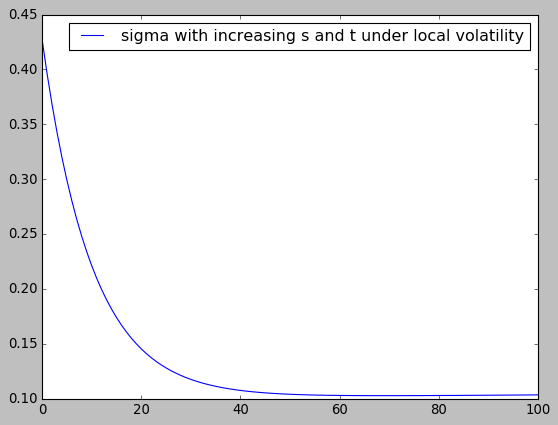

In [120]:
#The local volatility function is given by:
sigma = (1+t_2/30)*(0.1+0.4*np.exp(-s/50))

fig, ax = plt.subplots()
ax.plot(sigma, label="sigma with increasing s and t under local volatility")
ax.legend()

# *Explicit scheme*

Under explicit scheme the PDE can be discretised as

\begin{align*}
\frac{V^{n+1}_k-V^n_{k}}{\triangle t}&=\frac{\sigma^2(t,s) s_k^2}{2}\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+rs_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k \\
\implies \quad V^{n+1}_k&=\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(t,s) s_k^2}{2}-\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k-1}+\left(1-\frac{ \triangle t}{\triangle x^2}\sigma^2(t,s) s_k^2-\triangle t r\right)V^n_k\\
&\qquad +\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(t,s) s_k^2}{2}+\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k+1}\\
&=A_k V^n_{k-1} +(1+B_k) V^n_{k}+C_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, where
\begin{align}
A_k:=\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(t,s) s_k^2}{2}-\frac{\triangle t}{2\triangle x}rs_k,\qquad B_k:=-\frac{ \triangle t}{\triangle x^2}\sigma^2(t,s) s_k^2-\triangle t r,\qquad C_k:=\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(t,s) s_k^2}{2}+\frac{\triangle t}{2\triangle x}rs_k
\end{align}

In [8]:
# Set up the vectors A, B and C
A = 0.5 * sigma**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
B = - sigma**2 * dt / dx**2 * s**2 - r * dt
C = 0.5 * sigma**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

Recall that the $M-1$ recursive equations can be summarised using matrix notation
\begin{align*}
\underbrace{
\begin{bmatrix}
V^{n+1}_0 \\ 
V^{n+1}_1 \\ 
V^{n+1}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n+1}_{M-1}\\ 
V^{n+1}_M  
\end{bmatrix}}_{=:V^{n+1}}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
A^n_1 & 1+B^n_1 & C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & A^n_2 & 1+B^n_2 &C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & A^n_{M-2} &  1+B^n_{M-2}& C^n_{M-2}& 0\\ 
 &  &  &  &  &0 & A^n_{M-1} & 1+B^n_{M-1} & C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &1 
\end{bmatrix}}_{=:\mathbb{I}+L^n}
\underbrace{
\begin{bmatrix}
V^{n}_0 \\ 
V^{n}_1 \\ 
V^{n}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n}_{M-1}\\ 
V^{n}_M  
\end{bmatrix}}_{=:V^{n}}
\end{align*}
Here $\mathbb{I}$ is an $(M+1)\times (M+1)$ identity matrix and $L^n$ is an $(M+1)\times (M+1)$ matrix in form of
\begin{align}
L^n:=
\begin{bmatrix}
0 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
A^n_1 & B^n_1 & C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & A^n_2 & B^n_2 &C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & A^n_{M-2} &  B^n_{M-2}& C^n_{M-2}& 0\\ 
 &  &  &  &  &0 & A^n_{M-1} & B^n_{M-1} & C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &0
\end{bmatrix}
\end{align}

In our specific example, $A$, $B$ and $C$ (and in turn the matrix $L$) have no dependence on $n$ and hence can be pre-set before running the loop.

In [9]:
# Setup the matrix L and I
a_diag = np.concatenate([A[1:-1],[0]])
b_diag = np.concatenate([[0],B[1:-1],[0]])
c_diag = np.concatenate([[0],C[1:-1]])
L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
I = np.identity(M+1)

Recall that the system $V^{n+1}=(\mathbb{I}+L^n) V^n$ doesn't give us the correct value of $V^{n+1}_0$ and $V^{n+1}_M$. We need to manually overwrite the first and last entry of the vector to incorporate the boundary conditions at $s=s_0=s_{min}$ and $s=s_M=s_{max}$. The complete recursive algorithm is: 
\begin{align}
V^{n+1}=B^{n+1}((\mathbb{I}+L^n) V^{n})
\end{align}
where $B^{n+1}(\cdot)$ is an operator which overwrites the first and last entry of the input vector to $\ell^{n+1}_0:=\ell(t_{n+1},x_0)$ and $u^{n+1}_{M}:=u(t_{n+1},x_M)$.

In [10]:
# Running the explicit scheme

# Initial condition
v_ex = np.maximum(s - K, 0) # call option payoff

# Iteration of explicit scheme
for n in range(1,N+1):
    v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
    v_ex[0] = 0                           # Boundary operation at s_min
    v_ex[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max
    
# Running the implicit scheme

# *Fully implicit scheme*

Under fully implicit scheme the PDE is now discretised as

\begin{align*}
\frac{V^{n}_k-V^{n-1}_{k}}{\triangle t}&=\frac{\sigma^2(t,s) s_k^2}{2}\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+rs_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k \\
\implies \quad V^{n-1}_k&=-\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(t,s) s_k^2}{2}-\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k-1}+\left(1+\frac{ \triangle t}{\triangle x^2}\sigma^2(t,s) s_k^2+\triangle t r\right)V^n_k\\
&\qquad -\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(t,s) s_k^2}{2}+\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k+1}\\
&=-A_k V^n_{k-1} +(1-B_k) V^n_{k}-C_k V^n_{k+1}
\end{align*}
for $A$, $B$ and $C$ are defined previously. After taking boundary condition into account, a matrix representation is
\begin{align*}
\begin{bmatrix}
1 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
-A^n_1 & 1-B^n_1 & -C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & -A^n_2 & 1-B^n_2 &-C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & -A^n_k &  1-B^n_k& -C^n_k& 0\\ 
 &  &  &  &  & 0& -A^n_{M-1} & 1-B^n_{M-1} & -C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &1 
\end{bmatrix}
\begin{bmatrix}
V^{n}_0 \\ 
V^{n}_1 \\ 
V^{n}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n}_{M-1}\\ 
V^{n}_M  
\end{bmatrix}
=
\begin{bmatrix}
\ell^{n}_0 \\ 
V^{n-1}_1 \\ 
V^{n-1}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n-1}_{M-1}\\ 
u^{n}_M  
\end{bmatrix}
\end{align*}
In matrix form, it can be represented as
\begin{align}
(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).
\end{align}

To solve $V^{n}$, we implement the Thomas algorithm which solves system of equation $Ax=d$ with $A$ being a tridiagonal matrix of the form
\begin{align*}
\begin{bmatrix}
b_0 & c_0 & 0 &  \cdots&  &  &  &0 &0 \\ 
a_1 & b_1 & c_1 & 0 & \cdots &  &  &0 &0 \\ 
0 & a_2 & b_2 &c_2  & 0 &\cdots  &  & &  \\ 
 &  &  &  & \ddots & &  &  &   \vdots\\ 
 \vdots&  &  &  &  & a_{M-2} & b_{M-2}& c_{M-2}& 0 \\ 
 &  &  &  &  & 0& a_{M-1} & b_{M-1} & c_{M-1} \\ 
 0&0  &\cdots  &  & & 0& 0 & a_M &b_M 
\end{bmatrix}
\end{align*}

In [11]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

Now we run the iteration to solve the resursion
\begin{align}
(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).
\end{align}

In [12]:
# Running the implicit scheme

# Initial condition
v_im = np.maximum(s - K, 0)

# Iteration of implicit scheme
for n in range(1,N+1):
    
    d = v_im   # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at s_min
    d[M] = s_max - K*np.exp(-r*t[n])  # Boundary operator at s_min
    v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

# *The Crank-Nicolson scheme*

\begin{align*}
\frac{V^{n}_k-V^{n-1}_{k}}{\triangle t}&=\theta\left(\frac{\sigma^2(t,s) s_k^2}{2}\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+rs_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k\right) + \\
&(1-\theta)\left(\frac{\sigma^2(t-1,s) s_k^2}{2}\frac{V^{n-1}_{k+1}-2V^{n-1}_k+V^{n-1}_{k-1}}{\triangle x^2}
+rs_k \frac{V^{n-1}_{k+1}-V^{n-1}_{k-1}}{2\triangle x}-r V^{n-1}_k\right)\\
\end{align*}

Based on the same idea as in the analysis of the explicit/implicit scheme, the recursive equations and the boundary conditions can be summarised by the following matrix notation:

\begin{align}
(\mathbb{I}-\theta L^{n})V^{n}=B^{n}(\mathbb{I}+(1-\theta) L^{n-1})V^{n-1}).
\end{align}

In [13]:
# Running the implicit scheme

theta= 1/2 #Fixed by the Crank-Nicolson scheme
# Initial condition
v_cr_ni = np.maximum(s - K, 0)

# Iteration of implicit scheme

for n in range(0,N):
    v_cr_ni = np.matmul(I+(1-theta)*L, v_cr_ni)           # V^{n+1} = (I+(1-theta)*L)V^n
    v_cr_ni[0] = 0                           # Boundary operation at s_min
    v_cr_ni[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max
        
for n in range(1,N+1):
    
    d = v_cr_ni   # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at s_min
    d[M] = s_max - K*np.exp(-r*t[n])  # Boundary operator at s_min
    v_cr_ni = TDMAsolver(-a_diag*theta, 1-b_diag*theta, -c_diag*theta, d)   # Run the Thomas algorithm to solve for V^n


In [ ]:
"""
For theta=0, we should recover the Explicit Scheme.
For theta=1, we should recover the Fully Implicit Scheme.

Run the below for both theta for sanity check:
print(v_cr_ni)
print(v_im)
print(v_ex)
"""

# **Prices obtained with the three schemes**

We compare the our finite difference approximations against that of the Black-Scholes solution.

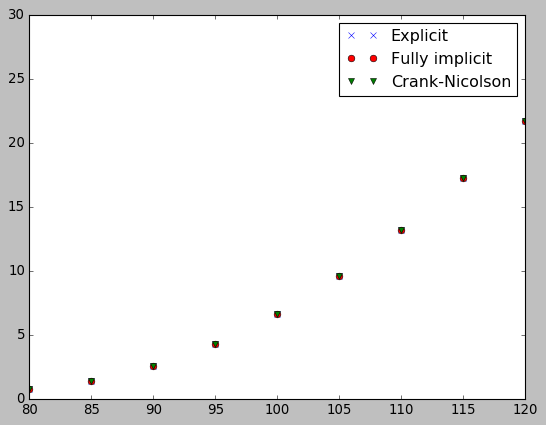

In [25]:
fig, ax = plt.subplots()
ax.plot(s, v_ex, 'x', linewidth=0.5, color="b",label="Explicit")
ax.plot(s, v_im, 'o', linewidth=0.5, color="r", label="Fully implicit")
ax.plot(s, v_cr_ni, "v", linewidth=0.5, color="g", label="Crank-Nicolson")
ax.set_xlim([80, 120])
ax.set_ylim([0, 30])
ax.legend()

In [16]:
s_range_80_120 = s[14:23]
v_ex_range_80_120 = v_ex[14:23]
v_im_range_80_120 = v_im[14:23]
v_cr_ni_range_80_120 = v_cr_ni[14:23]

Table_prices_schemes=pd.DataFrame({"Stock Price":s_range_80_120,"Explicit Scheme Prices":v_ex_range_80_120,
                                   "Implicit Scheme Prices":v_im_range_80_120, 
                                   "Crank-Nicolson Scheme Prices":v_cr_ni_range_80_120})

Table_prices_schemes

,Stock Price,Explicit Scheme Prices,Implicit Scheme Prices,Crank-Nicolson Scheme Prices
0,80.0,0.708623,0.709268,0.708946
1,85.0,1.399338,1.399475,1.399406
2,90.0,2.534719,2.534094,2.534406
3,95.0,4.237428,4.236102,4.236765
4,100.0,6.583896,6.582263,6.583079
5,105.0,9.581941,9.580521,9.581231
6,110.0,13.170821,13.169979,13.170400
7,115.0,17.242413,17.242219,17.242316
8,120.0,21.671686,21.671972,21.671829


In [20]:
# Black-Scholes call option formula
def euro_vanilla_call(S, K, T, r, sigma):
        
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

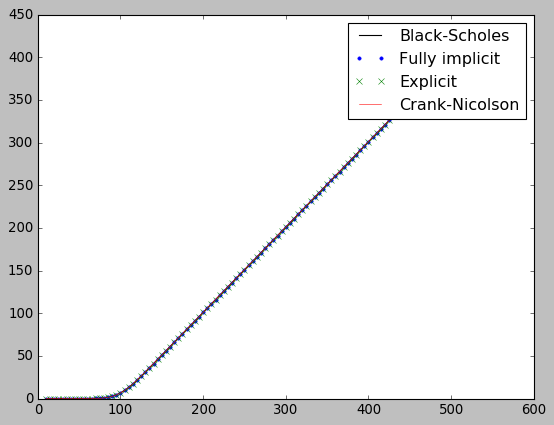

In [47]:
bscall = euro_vanilla_call(s, K, T, r, sigma)

# Plot the results under explicit and fully implicit scheme
fig, ax = plt.subplots()
ax.plot(s, bscall, 'k-', label="Black-Scholes")
ax.plot(s, v_im, '.', linewidth=0.5, label="Fully implicit")
ax.plot(s, v_ex, 'x', linewidth=0.5, label="Explicit")
ax.plot(s, v_cr_ni, linewidth=0.5, label="Crank-Nicolson")
ax.legend()

as we can see prices converge towards BS

## Part 2: Implied Vol under the local volatility model

Code copied shamelessly from: https://stackoverflow.com/questions/61289020/fast-implied-volatility-calculation-in-python

In [27]:
import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return round(sigma,3) # value wasn't found, return best guess so far



To make the code less heavy we write functions to compute the price under the explicit and implicit scheme as per below:

In [35]:
def grid_setup(s_min,s_max,T,N,M,sigma,local_vol):
    # Setup of grids
    dt = T/N
    dx = (s_max - s_min)/M
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)
    t_2 = np.linspace(0, T, M+1)
    #local_vol
    if local_vol == True:
        sigma = (1+t_2/30)*(0.1+0.4*np.exp(-s/50))
    else:
        sigma = sigma
        
    # Set up the vectors A, B and C
    A = 0.5 * sigma**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
    B = - sigma**2 * dt / dx**2 * s**2 - r * dt
    C = 0.5 * sigma**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s
    # Setup the matrix L and I
    a_diag = np.concatenate([A[1:-1],[0]])
    b_diag = np.concatenate([[0],B[1:-1],[0]])
    c_diag = np.concatenate([[0],C[1:-1]])
    L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
    I = np.identity(M+1)
    return I,L,s, a_diag, b_diag, c_diag, t 

In [36]:
def VanillaEU_Call_Finite_Diff(S0,K,r,sigma,T,local_vol=True,explicit=True):
    # Grid parameters
    s_min, s_max = 10, 150
    N, M = (s_max-s_min)*10, s_max-s_min
    # Setup of grids
    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Running the explicit scheme

    # Initial condition
    v_ex = np.maximum(s - K, 0) # call option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = 0                           # Boundary operation at s_min
        v_ex[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(s - K, 0)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s_min
        d[M] = s_max - K*np.exp(-r*t[n])  # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
        
    return v_ex[S0-s_min] if explicit==True else v_im[S0-s_min]

In [55]:
#Example 
print(VanillaEU_Call_Finite_Diff(100,K,r,sigma,T,explicit=False))
euro_vanilla_call(100, K, T, r, 0.157) #where we chose a vol=15.7% not too far from the local vol values 

6.7553662232161376


6.735945036335941

### Under constant volatility

In [ ]:
bscall = euro_vanilla_call(s, K, T, r, sigma)

# Plot the results under explicit and fully implicit scheme
fig, ax = plt.subplots()
ax.plot(s, bscall, 'k-', label="Black-Scholes")
ax.plot(s, v_im, '.', linewidth=0.5, label="Fully implicit")
ax.plot(s, v_ex, 'x', linewidth=0.5, label="Explicit")
ax.plot(s, v_cr_ni, linewidth=0.5, label="Crank-Nicolson")
ax.legend()

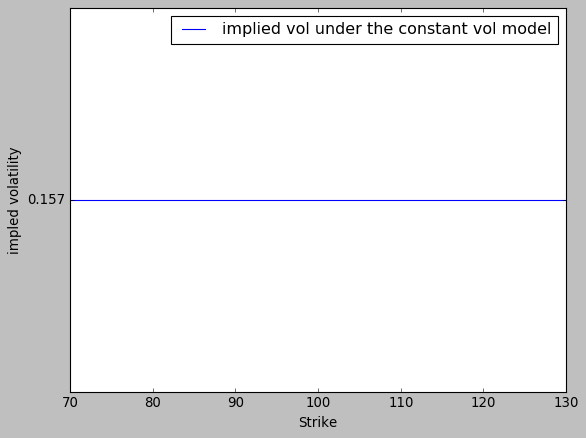

In [96]:
S0,r,sigma,T=100,0.1,0.157,1
K_range=[i for i in range(70,135,5)]
impl_vol_range_constant_vol=[find_vol(VanillaEU_Call_Finite_Diff(S0,i,r,sigma,T,local_vol=False,explicit=True), S0, i, T, r)
                             for i in range(70,135,5)]
impl_vol_range_constant_vol_rounded = [ '%.3f' % elem for elem in impl_vol_range_constant_vol ]
fig, ax = plt.subplots()
ax.plot(K_range, impl_vol_range_constant_vol_rounded, label="implied vol under the constant vol model")
plt.ylabel('impled volatility') 
plt.xlabel('Strike')
ax.legend()

### Under Local volatility

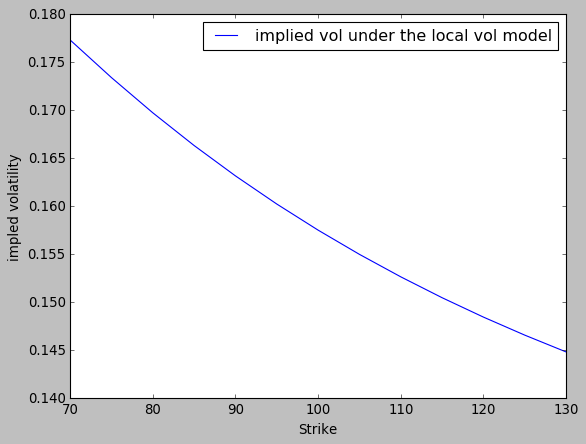

In [97]:
S0,r,sigma,T=100,0.1,0.157,1 #NB: the function will ignore sigma=0.157 when local_vol=true
impl_vol_range_local_vol=[find_vol(VanillaEU_Call_Finite_Diff(S0,i,r,sigma,T,local_vol=True,explicit=False), S0, i, T, r) 
                         for i in range(70,135,5)]
fig, ax = plt.subplots()
ax.plot(K_range, impl_vol_range_local_vol, label="implied vol under the local vol model")
plt.ylabel('impled volatility') 
plt.xlabel('Strike')
ax.legend()

In [126]:
S0,r,sigma,T=100,0.1,0.157,1
K_range=[i for i in range(70,135,5)]
Prices_constant_vol=[VanillaEU_Call_Finite_Diff(S0,i,r,sigma,T,local_vol=False,explicit=True) for i in range(70,135,5)]
Prices_local_vol=[VanillaEU_Call_Finite_Diff(S0,i,r,sigma,T,local_vol=True,explicit=True) for i in range(70,135,5)]

Prices_local_vol_table=pd.DataFrame({"K":K_range,"Prices":Prices_local_vol})
Prices_local_vol_table

,K,Prices
0,70,36.684026
1,75,32.200437
2,80,27.771092
3,85,23.445192
4,90,19.295158
5,95,15.413203
6,100,11.899479
7,105,8.843601
8,110,6.305200
9,115,4.300575


## Part 3: Pricing Down-and-in Put under the finite difference method: Implicit Scheme

We will first go through the DOP Valuation through the Implicit Method. Once we obtain the price for a DOP, we can easily get the DIP using the in-out parity: Put = DIP + DOP.

In the below we will go step by step: defining the grid and boundary coundition then go through both the explicit and implicit scheme. Once done, we will define functions to make the writing less heavy on the lector for UOC/UIC/DIP.

It is straightforward to formulate the PDE satisfied by a knock-out barrier option. All we need to do is to introduce a
suitable boundary condition where the option value is set to zero at the knock-out level.

For any t, we expect V(t, Bko) = 0 because the current stock price has now crossed the barrier and the option van-
ishes.

Under the Black-Scholes model, V satisfies the PDE:

\begin{align} 
&\frac{\partial V}{\partial t}=rs\frac{\partial V}{\partial s} + \frac{\sigma^2(t,s) s^2}{2}\frac{\partial^2 V}{\partial s^2} -r V = 0,  &t>0 \\ \label{eq3)14}
&V(T, B_{ko})=0, &t>0\\  \label{eq15}
&V(T, s)=(K - s)^{+}𝟙_{(s\geqslant B_{ko})]}, &t=0\\  \label{eq16}
\nonumber
\end{align}

# *Setup of the grid and boundary condition*

*Boundary condition*

In this example we will work with the domain of $(t,s)$ directly which is truncated to $D:=[0,T]\times [B_{ko},s_{max}]$. Since a Put option is involved, we impose the boundary conditions
\begin{align}
V(t,B_{ko})=0,\qquad V(t,s_{max})=0 \qquad \text{for all } t<T
\end{align}
<br>
<br>
*Grid specification*

We use exactly the same approach as before and solve for the price using the boundary conditions we have specified before

In [98]:
def EU_Put_Down_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=True):
    # Grid parameters
    s_min, s_max = Bko, 150
    N, M = abs(s_max-s_min)*10, abs(s_max-s_min)  # N = 1000, M = 100

    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Initial condition
    v_ex = (K-s)*np.int64(K >= s)*np.int64(s >= Bko) # DOP option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = 0                           # Boundary operation at s_min
        v_ex[M] = 0                           # Boundary operation at s_max  

    # Running the implicit scheme

    # Initial condition
    v_im = (K-s)*np.int64(K > s)*np.int64(s > Bko)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s_min
        d[M] = 0  # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
    
    return v_ex[S0-Bko] if explicit==True else v_im[S0-Bko]


In [99]:
def VanillaEU_Put_Finite_Diff(S0,K,r,sigma,T,local_vol=False,explicit=True):
    # Grid parameters
    s_min, s_max = 10, 150
    N, M = (s_max-s_min)*10, s_max-s_min
    # Setup of grids
    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Running the explicit scheme

    # Initial condition
    v_ex = np.maximum(K - s, 0) # call option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = K*np.exp(-r*t[n])           # Boundary operation at s_min
        v_ex[M] = 0                           # Boundary operation at s_max

    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(K - s, 0)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = K*np.exp(-r*t[n])   # Boundary operator at s_min
        d[M] = 0                   # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
        
    return v_ex[S0-10] if explicit==True else v_im[S0-10]

In [101]:
def EU_Put_Down_In_Finite_Diff_implicit(S0,Bko,K,r,sigma,T,local_vol=False):
    if local_vol==True:
        return VanillaEU_Put_Finite_Diff(S0,K,r,sigma,T,local_vol=True, 
            explicit=False) - EU_Put_Down_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=True,explicit=False)
    else:
        return VanillaEU_Put_Finite_Diff(S0,K,r,sigma,T,local_vol=False, 
            explicit=False) - EU_Put_Down_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=False)

In [116]:
#Implicit prices
S0,K,r,sigma,T=100,100,0.01,0.157,1

DIP_prices_constant_volatility = [EU_Put_Down_In_Finite_Diff_implicit(S0,i,K,r,sigma,T) 
                                           for i in range(60,100,10)]
DIP_prices_constant_volatility

[0.04989699249811963, 0.7130397820488081, 3.106386822981131, 5.429516289455524]

In [107]:
DIP_prices_local_volatility = [EU_Put_Down_In_Finite_Diff_implicit(S0,i,K,r,sigma,T,local_vol=True) 
                                           for i in range(60,100,10)]
DIP_prices_local_volatility

[0.2567757594107487, 1.232085259294018, 3.495762531309088, 5.47913701756384]

In [115]:
Bin_range = [i for i in range(60,100,10)]
DIP_prices_table = pd.DataFrame({"Bin_range":Bin_range,"DIP_prices_constant_volatility":DIP_prices_constant_volatility,
                                "DIP_prices_local_volatility":DIP_prices_local_volatility})
DIP_prices_table["% Difference"] = \
    DIP_prices_table["DIP_prices_local_volatility"]/DIP_prices_table["DIP_prices_constant_volatility"] - 1
DIP_prices_table

,Bin_range,DIP_prices_constant_volatility,DIP_prices_local_volatility,% Difference
0,60,0.049897,0.256776,4.146117
1,70,0.713040,1.232085,0.727933
2,80,3.106387,3.495763,0.125347
3,90,5.429516,5.479137,0.009139
